<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/ToyCircleRegression2Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Attempt to add the uber code as tested into this


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


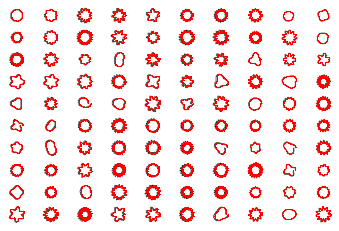

In [ ]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
    
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample,torch.zeros(64,1000,2).cuda())#come back to this
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            
            s = [.0001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        z = torch.zeros(numpoints,1)
        points = torch.cat([points,z], dim = 1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=1200)
        
dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [ ]:
dataset[0][0].shape

torch.Size([32, 32])

In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = self.input_dim*0#if I remove the 10, i get typical results with blur
        self.output_dim = 1000*2

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, 100*self.input_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(100*self.input_dim, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, x,points):
        x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        assert x.shape == (mini_batch,self.input_dim)
        out = self.mlp(x)
        return 32.0*out.reshape(points.shape)


In [ ]:
model = MLP().cuda()
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [ ]:
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [ ]:
for i in range(20):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    
    out = model(xin,yin[:,:,:2])
    loss = torch.mean((out-yin[:,:,:2])**2)
    loss.backward()
    optimizer.step()
  print("loss",loss.item())
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.04668975993990898
loss 0.0460532084107399
loss 0.04174083098769188
loss 0.040984056890010834
loss 0.038694608956575394
loss 0.040023379027843475
loss 0.040880393236875534
loss 0.03946831822395325
loss 0.03902551531791687
loss 0.039163317531347275
loss 0.03958858549594879
loss 0.038440898060798645
loss 0.0362946093082428
loss 0.03770167753100395
loss 0.03626945614814758
loss 0.03972300887107849
loss 0.035999856889247894
loss 0.03660032898187637
loss 0.03427508845925331
loss 0.03411373496055603


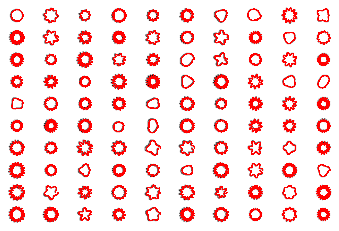

In [ ]:
DonutDataset.displayCanvas('post_train_model.png',dataset, model = model)


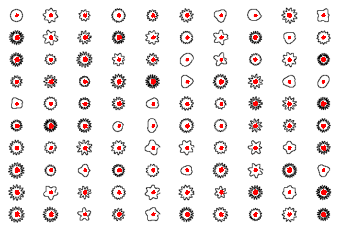

In [ ]:
modelrandom = MLP().cuda()
DonutDataset.displayCanvas('random_model.png',dataset, model = modelrandom)


In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset_test = DonutDataset(length = 100)
loader_test = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_test),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
lossTotal = 0.0
count = 0
for xin,yin in loader_test:
  optimizer.zero_grad()
  if xin.shape[0] != 64:
    print(xin.shape)
    continue
  xin = xin.cuda()
  yin = yin.cuda()
  
  out = model(xin,yin[:,:,:2])
  loss = torch.mean((out-yin[:,:,:2])**2)
  loss.backward()
  lossTotal+=loss.item()
  count+=1
  optimizer.step()

print("validation loss",lossTotal/count)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([36, 32, 32])
validation loss 0.034324128180742264


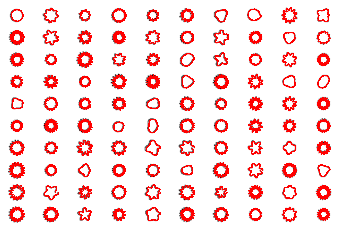

In [ ]:
DonutDataset.displayCanvas('testset_model.png',dataset, model = model)


Fan out for success!

I think I need to give the model the first x0,y0 coordinate in addition to all the other information.

Ablation:\
Network depth helps\
Network width helps\
Probably lower learning rate and long running times helps \
\
note:\
worth noting one of the ameba columns always starts at the same place